# Readme
这个notebook用于画出论文中要用到的图3

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import copy
import argparse
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression
import json
from utils.tools import dotdict
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from matplotlib import cm
from scipy import stats
import math
from scipy.optimize import curve_fit
import matplotlib
from data_provider.data_loader import fixed_files
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_absolute_error

from matplotlib.font_manager import FontProperties
from scipy.stats import wilcoxon, ttest_ind, mannwhitneyu, ttest_rel

font = {'family' : 'Arial'}

matplotlib.rcParams['mathtext.fontset'] = 'custom'

matplotlib.rcParams['mathtext.rm'] = 'Arial'

matplotlib.rcParams['mathtext.it'] = 'Arial'

matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42 # make the text editable for Adobe Illustrator
matplotlib.rcParams['ps.fonttype'] = 42
#matplotlib.rc('font', **font0)

# matplotlib.rc('text', usetex=False)
def set_ax_linewidth(ax, bw=1.5):
    ax.spines['bottom'].set_linewidth(bw)
    ax.spines['left'].set_linewidth(bw)
    ax.spines['top'].set_linewidth(bw)
    ax.spines['right'].set_linewidth(bw)

def set_ax_font_size(ax, fontsize=10):
    ax.tick_params(axis='y',
                 labelsize=fontsize # y轴字体大小设置
                  ) 
    ax.tick_params(axis='x',
                 labelsize=fontsize # x轴字体大小设置
                  ) 

def set_draft(the_plt, other_ax=''):
    ax = the_plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.xlabel('')
    plt.ylabel('')
    if other_ax:
        other_ax.axes.xaxis.set_ticklabels([])
        other_ax.axes.yaxis.set_ticklabels([])
        other_ax.set_ylabel('')
        other_ax.set_xlabel('')

def set_draft_fig(fig):
    for ax in fig.axes:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.set_ylabel('')
        ax.set_xlabel('')
    
x_y_label_size = 12 
title_size = 12 
convert_mm_to_inch = 1/25.4
dot_size = 9

这里写上a、b、c三个图的绘图函数的实现

In [26]:
def convert_pvalue_to_asterisks(pvalue):
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"

def plot_significane(ax, Xs,Ys,P_value,height=0.2):
    '''
    ax: The matplotlib.axes to conduct the plot
    Xs: The x-coordinates of the line
    Ys: The y-coordinates of the line
    P_value: The significance test value
    height: The vertical line height
    '''
    # plot the line
    Ys[1] += height
    Ys[2] += height
    ax.plot(Xs, Ys, lw=2, c='#595959')
    # ax.text((Xs[0]+Xs[2])*0.5, Ys[0]+height,convert_pvalue_to_asterisks(P_value), ha='center', va='bottom', color="k")
    ax.text((Xs[0]+Xs[2])*0.5, Ys[0]+height,"%.2f" % P_value, ha='center', va='bottom', color="k")
    
def plot_overal_performance(NCA_model_paths, LFP_model_paths):
    def collect_preds(cycleNumber_preds):
        '''Collect the preds from each cycle number'''
        cycleNumber_preds = list(cycleNumber_preds.values())
        total_preds = []
        for preds in cycleNumber_preds:
            total_preds += [np.mean(preds,axis=1)]
        total_preds = np.concatenate(total_preds,axis=0)
        return total_preds
    
    fig,(ax1,ax2) = plt.subplots(1,2,
                                    figsize=(7,4),
                                    dpi=600,
                                    sharey=False)
    ''' 根据trajectory上的每一个预测值来做显著性分析 '''
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer'] # the model names
    plot_colors = []
    plot_labels = []
    NCA_model_scores = {} # This includes the averaged scores for five conditions
    NCA_model_detailedScores = {} # This includes the averaged scores for each cell in the testing set
    NCA_model_detailedSampleScores = {}
    LFP_model_scores = {} # This includes the averaged scores for five conditions
    LFP_model_detailedScores = {} # This includes the averaged scores for each cell in the testing set
    LFP_model_detailedSampleScores = {}

    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        if 'FT' in NCA_mp or 'DA' in NCA_mp:
            # fine-tune is not considered in this figure
            continue
        LFP_mp = LFP_model_paths[index]
        the_color = colors[index]

        model_name = model_names[index]
        plot_colors.append(the_color)
        plot_labels.append(model_name)
        # save the NCA data
        with open(f'{NCA_mp}file_detailed_alphas.json') as f:
            NCA_detailed_alphaAccs = json.load(f)
            condition_scores = {}
            for cell_name, alphaAccs in NCA_detailed_alphaAccs.items():
                condition = cell_name.split('_1-')[0]
                condition_scores[condition] = condition_scores.get(condition, []) + [np.mean(alphaAccs)]
                NCA_model_detailedSampleScores[model_name] = NCA_model_detailedSampleScores.get(model_name, []) + alphaAccs
            for condition, scores in condition_scores.items():
                NCA_model_detailedScores[model_name] = NCA_model_detailedScores.get(model_name, []) + [np.mean(scores)]
                NCA_model_scores[model_name] = NCA_model_scores.get(model_name, []) + [np.mean(scores)]
        # save the LFP data
        with open(f'{LFP_mp}file_detailed_alphas.json') as f:
            LFP_detailed_alphaAccs = json.load(f)
            condition_scores = {}
            for cell_name, alphaAccs in LFP_detailed_alphaAccs.items():
                condition = cell_name.split('_1-')[0]
                condition_scores[condition] = condition_scores.get(condition, []) + [np.mean(alphaAccs)]
                LFP_model_detailedSampleScores[model_name] = LFP_model_detailedSampleScores.get(model_name, []) + alphaAccs
            for condition, scores in condition_scores.items():
                LFP_model_detailedScores[model_name] = LFP_model_detailedScores.get(model_name, []) + [np.mean(scores)]
                LFP_model_scores[model_name] = LFP_model_scores.get(model_name, []) + [np.mean(scores)]
        
    # compute the significance test
    # for NCA
    for model_name, scores in NCA_model_scores.items():
        NCA_model_scores[model_name] = np.mean(scores)
    sorted_NCA_model_scores = sorted(NCA_model_scores.items(), key=lambda x:x[1], reverse=True)
    best_modelName, second_modelName = sorted_NCA_model_scores[0][0], sorted_NCA_model_scores[1][0]
    res = wilcoxon(NCA_model_detailedSampleScores[best_modelName],NCA_model_detailedSampleScores[second_modelName])
    p_value = res.pvalue
    # _, p_value = ttest_ind(NCA_model_detailedScores[best_modelName],NCA_model_detailedScores[second_modelName])
    print(f'NCA p-value:{p_value}')
    saved_NCA_data = {}
    for model_name, data in NCA_model_scores.items():
        saved_NCA_data[model_name] = [data]
    df = pd.DataFrame(saved_NCA_data)
    df.to_csv('./fig3/fig3a/NCA_data.csv',index=False)
    ax1.bar(x=plot_labels, height=list(NCA_model_scores.values()),color=plot_colors)
    plot_significane(ax1,[0,0,1,1],[max(list(NCA_model_scores.values()))+0.01 for _ in range(4)],p_value,height=0.01)

    y_major_locator=MultipleLocator(0.05)
        
    ax1.yaxis.set_major_locator(y_major_locator)
    ax1.set_xticks([])
    ax1.set_ylim((0.7,1.0))
    ax1.set_ylabel('alpha-accuracy')
    ax1.set_title('Overall NCA results')
    set_ax_font_size(ax1)
    set_ax_linewidth(ax1)
    custom_lines = [Line2D([0], [0], color=plot_colors[0],label=plot_labels[0], lw=5),
                    Line2D([0], [0], color=plot_colors[1],label=plot_labels[1], lw=5),
                    Line2D([0], [0], color=plot_colors[2],label=plot_labels[2], lw=5),
                    Line2D([0], [0], color=plot_colors[3],label=plot_labels[3], lw=5)]
    ax1.legend(handles=custom_lines)
    # for LFP
    for model_name, scores in LFP_model_scores.items():
        LFP_model_scores[model_name] = np.mean(scores)
    sorted_LFP_model_scores = sorted(LFP_model_scores.items(), key=lambda x:x[1], reverse=True)
    best_modelName, second_modelName = sorted_LFP_model_scores[0][0], sorted_LFP_model_scores[1][0]
    res = wilcoxon(LFP_model_detailedSampleScores[best_modelName],LFP_model_detailedSampleScores[second_modelName])
    p_value = res.pvalue
    # _, p_value = ttest_ind(LFP_model_detailedScores[best_modelName],LFP_model_detailedScores[second_modelName])
    print(f'LFP p-value:{p_value}')
    saved_LFP_data = {}
    for model_name, data in LFP_model_scores.items():
        saved_LFP_data[model_name] = [data]
    df = pd.DataFrame(saved_LFP_data)
    df.to_csv('./fig3/fig3a/LFP_data.csv',index=False)
    ax2.bar(x=plot_labels, height=list(LFP_model_scores.values()),color=plot_colors)
    plot_significane(ax2,[0,0,1,1],[max(list(LFP_model_scores.values()))+0.01 for _ in range(4)],p_value,height=0.01)

    y_major_locator=MultipleLocator(0.05)
        
    ax2.yaxis.set_major_locator(y_major_locator)
    ax2.set_xticks([])
    ax2.set_ylim((0.6,1.0))
    ax2.set_ylabel('alpha-accuracy')
    ax2.set_title('Overall NCA results')
    set_ax_font_size(ax2)
    set_ax_linewidth(ax2)
    fig.tight_layout()
    plt.savefig('./fig3/fig3a/a.pdf', bbox_inches = 'tight')
    plt.show()

def plot_overal_performance_cp(NCA_model_paths, LFP_model_paths):
    def collect_preds(cycleNumber_preds):
        '''Collect the preds from each cycle number'''
        cycleNumber_preds = list(cycleNumber_preds.values())
        total_preds = []
        for preds in cycleNumber_preds:
            total_preds += [np.mean(preds,axis=1)]
        total_preds = np.concatenate(total_preds,axis=0)
        return total_preds
    
    fig,(ax1,ax2) = plt.subplots(1,2,
                                    figsize=(7,4),
                                    dpi=600,
                                    sharey=False)
    ''' 根据trajectory上的每一个预测值来做显著性分析 '''
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer'] # the model names
    NCA_scores = []
    NCA_scores_Ed = []
    LFP_scores = []
    LFP_scores_Ed = []
    NCA_detailed_preds = [] # for each model, this list contains the scores of each condition
    LFP_detailed_preds = [] 
    plot_NCA_paths = []
    plot_LFP_paths = []
    plot_colors = []
    plot_labels = []


    for index in range(len(NCA_model_paths)):
        NCA_mp = NCA_model_paths[index]
        LFP_mp = LFP_model_paths[index]
        the_color = colors[index]
        if 'FT' in NCA_mp:
            # fine-tune is not considered in this figure
            continue
        plot_colors.append(the_color)
        plot_NCA_paths.append(NCA_mp)
        plot_LFP_paths.append(LFP_mp)
        plot_labels.append(model_names[index])
        with open(f'{NCA_mp}alpha_scores_Qd.json') as f:
            NCA_alphas = json.load(f)
            tmp_scores = []
            for condition, score in NCA_alphas.items():
                tmp_scores += [np.mean(score)]
            NCA_scores += [np.mean(tmp_scores)]
        with open(f'{NCA_mp}alpha_scores_Ed.json') as f:
            NCA_alphas = json.load(f)
            tmp_scores = []
            for condition, score in NCA_alphas.items():
                tmp_scores += [np.mean(score)]
            NCA_scores_Ed += [np.mean(tmp_scores)]
        NCA_scores[index] = (NCA_scores_Ed[index]+NCA_scores[index]) / 2
        with open(f'{NCA_mp}pred_trajectories.json') as f:
            NCA_pred_trajectories = json.load(f)
            tmp_model_preds = []
            for file, cycleNumber_preds in NCA_pred_trajectories.items():
                preds = collect_preds(cycleNumber_preds)
                tmp_model_preds += list(preds)
            NCA_detailed_preds += [tmp_model_preds]
        # get the Qd scores
        with open(f'{LFP_mp}alpha_scores_Qd.json') as f:
            LFP_alphas = json.load(f)
            tmp_scores = []
            for condition, score in LFP_alphas.items():
                tmp_scores += [np.mean(score)]
            LFP_scores += [np.mean(tmp_scores)]
        # get the Ed scores
        with open(f'{LFP_mp}alpha_scores_Ed.json') as f:
            LFP_alphas = json.load(f)
            tmp_scores = []
            for condition, score in LFP_alphas.items():
                tmp_scores += [np.mean(score)]
            LFP_scores_Ed += [np.mean(tmp_scores)]
        LFP_scores[index] = (LFP_scores_Ed[index]+LFP_scores[index]) / 2
        # prepare detailed scores for significance test
        with open(f'{LFP_mp}pred_trajectories.json') as f:
            LFP_pred_trajectories = json.load(f)
            tmp_model_preds = []
            for file, cycleNumber_preds in LFP_pred_trajectories.items():
                preds = collect_preds(cycleNumber_preds)
                tmp_model_preds += list(preds)
            LFP_detailed_preds += [tmp_model_preds]
    # save the NCA data
    NCA_plt3_df = pd.DataFrame({
        'MAGNet':[NCA_scores[0]],
        'Informer':[NCA_scores[1]],
        'ONe-shot LSTM': [NCA_scores[2]],
        'BiLSTM': [NCA_scores[3]]
    })
    NCA_plt3_df.to_csv('./fig3/fig3a/NCA_data.csv', index=False)
    ax1 = sns.barplot(x=plot_NCA_paths,y=NCA_scores,
                estimator=np.mean, capsize=.4,errwidth=1,errcolor="k",
                ax=ax1,palette=plot_colors)
    y_major_locator=MultipleLocator(0.05)
    
    ax1.yaxis.set_major_locator(y_major_locator)
    ax1.set_xticks([])
    ax1.set_ylim((0.8,1.0))
    ax1.set_ylabel('alpha-accuracy')
    ax1.set_title('Overall NCA results')
    avgScore_detailedScore = dict(zip(NCA_scores, NCA_detailed_preds))
    sorted_scores = sorted(avgScore_detailedScore.items(),reverse=True)
    res = wilcoxon(sorted_scores[0][1],sorted_scores[1][1])
    p_value = res.pvalue
    print(f'NCA p-value:{p_value}')
    plot_significane(ax1,[0,0,1,1],[max(NCA_scores)+0.01 for _ in range(4)],p_value,height=0.01)
    set_ax_font_size(ax1)
    set_ax_linewidth(ax1)
    custom_lines = [Line2D([0], [0], color=plot_colors[0],label=plot_labels[0], lw=5),
                Line2D([0], [0], color=plot_colors[1],label=plot_labels[1], lw=5),
                Line2D([0], [0], color=plot_colors[2],label=plot_labels[2], lw=5),
                Line2D([0], [0], color=plot_colors[3],label=plot_labels[3], lw=5)]
    ax1.legend(handles=custom_lines)
    # save the LFP data
    LFP_plt3_df = pd.DataFrame({
        'MAGNet':[LFP_scores[0]],
        'Informer':[LFP_scores[1]],
        'ONe-shot LSTM': [LFP_scores[2]],
        'BiLSTM': [LFP_scores[3]]
    })
    LFP_plt3_df.to_csv('./fig3/fig3a/LFP_data.csv', index=False)
    ax2 = sns.barplot(x=plot_LFP_paths,y=LFP_scores,
                estimator=np.mean, capsize=.4,errwidth=1,errcolor="k",
                ax=ax2,palette=plot_colors)
    
    y_major_locator=MultipleLocator(0.05)
    
    ax2.yaxis.set_major_locator(y_major_locator)
    ax2.set_xticks([])
    ax2.set_ylim((0.6,0.9))
    # 还需要添加显著性分析的画图代码
    # custom_lines = [Line2D([0], [0], color=plot_colors[0],label=plot_labels[0], lw=5),
    #             Line2D([0], [0], color=plot_colors[1],label=plot_labels[1], lw=5),
    #             Line2D([0], [0], color=plot_colors[2],label=plot_labels[2], lw=5),
    #             Line2D([0], [0], color=plot_colors[3],label=plot_labels[3], lw=5)]
    # ax2.legend(handles=custom_lines)
    ax2.set_title('Overall LFP results')
    avgScore_detailedScore = dict(zip(LFP_scores, LFP_detailed_preds))
    sorted_scores = sorted(avgScore_detailedScore.items(),reverse=True,key= lambda x:x[0])
    res = wilcoxon(sorted_scores[0][1],sorted_scores[1][1])
    p_value = res.pvalue
    print(f'LFP p-value:{p_value}')
    plot_significane(ax2,[0,0,1,1],[max(LFP_scores)+0.01 for _ in range(4)],p_value,height=0.01)
    set_ax_font_size(ax2)
    set_ax_linewidth(ax2)
    fig.tight_layout()
    plt.savefig('./fig3/a.pdf', bbox_inches = 'tight')
    plt.show()

def plot_alphaAcc_vs_sampleRatio(NCA_model_paths, source_length=10):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer'] # the model names
    total_sample_num = 0
    condition_sampleNum = {}
    with open(f'{NCA_model_paths[0]}pred_trajectories.json') as f:
        pred_trajectories = json.load(f)
    # count the sample number for each condition. This only needs to be conducted for one time.
    for file, cycleNumber_preds in pred_trajectories.items():
        condition = file.split('#')[0]
        tmpSampleNum = max([float(i) for i in list(cycleNumber_preds.keys())]) - source_length
        total_sample_num += tmpSampleNum
        condition_sampleNum[condition] = condition_sampleNum.get(condition,0) + tmpSampleNum
    condition_sampleNum = sorted(condition_sampleNum.items(), reverse=True,key= lambda x:x[1])
    sorted_conditions = [i[0] for i in condition_sampleNum]
    sample_ratios = [i[1] / total_sample_num for i in condition_sampleNum]
    fig=plt.figure(figsize=(7,5))
    for index in range(len(NCA_model_paths)-1,-1,-1):
        NCA_mp = NCA_model_paths[index]
        the_color = colors[index]
        model_name = model_names[index]
        with open(f'{NCA_mp}alpha_scores_Qd.json') as f:
            NCA_alphas = json.load(f)
            mean_alpha_scores = np.array([np.mean(NCA_alphas[c]) for c in sorted_conditions])
            std_alpha_scores = np.array([np.std(NCA_alphas[c]) for c in sorted_conditions])
        with open(f'{NCA_mp}alpha_scores_Ed.json') as f:
            NCA_alphas_Ed = json.load(f)
            mean_alpha_scores_Ed = np.array([np.mean(NCA_alphas_Ed[c]) for c in sorted_conditions])
            std_alpha_scores_Ed = np.array([np.std(NCA_alphas_Ed[c]) for c in sorted_conditions])
        mean_alpha_scores = (mean_alpha_scores + mean_alpha_scores_Ed) / 2
        std_alpha_scores = (std_alpha_scores + std_alpha_scores_Ed) / 2
        # plot
        plt.plot(sample_ratios, mean_alpha_scores, label=model_name, c=the_color,lw=2)
        plt.fill_between(sample_ratios, mean_alpha_scores+std_alpha_scores, mean_alpha_scores-std_alpha_scores, #上限，下限
        facecolor=the_color, #填充颜色
        edgecolor=the_color, #边界颜色
        alpha=0.2) #透明度
    # plt.plot(sample_ratios,[0.9 for _ in range(len(sample_ratios))],lw=2,c='r',linestyle=':', label=r'0.9 $\alpha$-accuracy')
    plt.vlines(sample_ratios,0.3,1.0,linestyles=':', colors='gray',lw=2)
    plt.legend()
    plt.ylabel('alpha-accuracy', fontsize=12)
    plt.xlabel('Sample ratio', fontsize=12)
    plt.ylim(0.3,1.0)
    plt.title('Results for different sample ratio on NCA dataset')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    fig.tight_layout()
    plt.savefig('./fig3/b.pdf', bbox_inches = 'tight')
    plt.show()

def plot_NCA_target_source_boxes(NCA_model_paths):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    my_pal = {"MAGNet": '#f08080', "Informer":'#1e90ff', "FT-Informer":'#808080', 'DA-Informer': '#eeb5a1'}
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer','DA-Informer'] # the model names
    box_model_names = ['MAGNet','Informer','FT-Informer','DA-Informer']
    
    model_condition_alphas = {}
    for model_name in box_model_names:
        model_condition_alphas[model_name] = {}
    total_alphas = []
    conditions = []
    total_model_names = []
    hue_name = ''
    
    for index in range(len(NCA_model_paths)):
        avg_alphas = {}
        NCA_mp = NCA_model_paths[index]
        model_name = model_names[index]
        if model_name not in box_model_names:
            continue
        with open(f'{NCA_mp}file_detailed_alphas.json') as f:
            file_detailed_alphas = json.load(f)
            for cell_name, alphas in file_detailed_alphas.items():
                cell_name = cell_name.split('_1-#')[0]
                condition = cell_name.split('NCA_')[-1]
                total_alphas += alphas
                conditions += [condition for _ in range(len(alphas))]
                total_model_names += [model_name for _ in range(len(alphas))]
                
                avg_alphas[condition] = avg_alphas.get(condition, []) + [float(np.mean(alphas))]
                
        for condition, data in avg_alphas.items():
            model_condition_alphas[model_name][condition] = np.mean(data)
    for model, condition_alphas in model_condition_alphas.items(): 
        print(condition_alphas)
        model_condition_alphas_df = pd.DataFrame({
            'Condition':list(condition_alphas.keys()),
            'Average alpha accuracy': list(condition_alphas.values())
        })
        model_condition_alphas_df.to_csv(f'./fig3/fig3b/NCA_alpha_accuracy_linePlot_{model}.csv',index=False)
    # fig = plt.figure(figsize=(6,4))
    # plt.plot(model_condition_alphas_df['Average alpha accuracy'].values, marker='o')
    # plt.show()
    fig = plt.figure(figsize=(6,4))
    df = pd.DataFrame({hue_name:total_model_names,
                       'alpha-acc':total_alphas,
                       'Conditions':conditions})   
    df.to_csv('./fig3/fig3b/NCA_boxplot.csv',index=False)
    ax=sns.boxplot(x='Conditions',y='alpha-acc', hue=hue_name,whis=1.5, data=df,width=0.7,palette=my_pal, order=['CY25-1','CY25-025','CY25-05','CY35-05','CY45-05'],
                boxprops={'linewidth':0}, whiskerprops={'color':'k'},hue_order=['MAGNet','Informer','DA-Informer','FT-Informer'])   
    ax.legend_.remove()
    plt.axvline(1-0.5,c='k')
    plt.title('Results of target and source conditions on NCA dataset')
    plt.xlabel('Conditions')
    plt.ylabel('alpha-accuracy')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    fig.tight_layout()
    plt.savefig('./fig3/fig3b/b.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def plot_NCA_target_source_boxes_all(NCA_model_paths):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    my_pal = {"MAGNet": '#f08080', "Informer":'#1e90ff', 
              "FT-Informer":'#808080', "One-shot LSTM": '#800080',
              "BiLSTM": '#ffa500','DA-Informer':'#eeb5a1'}
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer','DA-Informer'] # the model names
    
    model_condition_alphas = {}
    for model_name in model_names:
        model_condition_alphas[model_name] = {}
    box_model_names = model_names
    total_alphas = []
    cell_names = []
    total_model_names = []
    conditions = []
    hue_name = ''
    fig = plt.figure(figsize=(10,4))
    for index in range(len(NCA_model_paths)):
        avg_alphas = {}
        NCA_mp = NCA_model_paths[index]
        model_name = model_names[index]
        if model_name not in box_model_names:
            continue
        with open(f'{NCA_mp}file_detailed_alphas.json') as f:
            file_detailed_alphas = json.load(f)
            for cell_name, alphas in file_detailed_alphas.items():
                cell_name = cell_name.split('_1-#')[0]
                condition = cell_name.split('NCA_')[-1]
                total_alphas += alphas
                conditions += [condition for _ in range(len(alphas))]
                total_model_names += [model_name for _ in range(len(alphas))]
                
                avg_alphas[condition] = avg_alphas.get(condition, []) + [float(np.mean(alphas))]
                
        for condition, data in avg_alphas.items():
            model_condition_alphas[model_name][condition] = np.mean(data)
    for model, condition_alphas in model_condition_alphas.items(): 
        print(condition_alphas)
        model_condition_alphas_df = pd.DataFrame({
            'Condition':list(condition_alphas.keys()),
            'Average alpha accuracy': list(condition_alphas.values())
        })
        model_condition_alphas_df.to_csv(f'./fig3/SI/NCA_alpha_accuracy_linePlot_{model}.csv',index=False)
    df = pd.DataFrame({hue_name:total_model_names,
                       'alpha-acc':total_alphas,
                       'Conditions':conditions})   
    ax=sns.boxplot(x='Conditions',y='alpha-acc', hue=hue_name,whis=1.5, data=df,width=0.7,palette=my_pal, order=['CY25-1','CY25-025','CY25-05','CY35-05','CY45-05'],
                boxprops={'linewidth':0}, whiskerprops={'color':'k'})   
    # ax=sns.barplot(x='Conditions',y='alpha-acc', hue=hue_name, data=df, palette=my_pal, order=['CY25-1','CY25-025','CY25-05','CY35-05','CY45-05'],
    #             errorbar='sd',err_kws={'lw':1.5},capsize=0.2,saturation=1,hue_order=['MAGNet','Informer','One-shot LSTM','BiLSTM','DA-Informer','FT-Informer'])   
    ax.legend_.remove()
    plt.axvline(1-0.5,c='k')
    plt.title('Results of target and source conditions on NCA dataset')
    plt.xlabel('Conditions')
    plt.ylabel('alpha-accuracy')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    fig.tight_layout()
    plt.savefig('./fig3/SI/NCA_boxplot_all.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def plot_LFP_seen_unseen_boxes_beforeTYZHANG(LFP_model_paths, rank_from_large_imrpvoement_to_low=False):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer'] # the model names
    unseen_files = fixed_files.NE_unseen_test_files
    seen_files = [i for i in fixed_files.NE_test_files if i not in unseen_files]
    unseen_files = [i.split('.')[0] for i in unseen_files]
    seen_files =  [i.split('.')[0] for i in seen_files]
    total_model_names = []
    cell_names = []
    total_alphas = []
    hue_name = ''
    fig=plt.figure(figsize=(12,4))


    for index in range(len(LFP_model_paths[:2])):
        # The first two paths are paths to our model and Informer respeectively.
        LFP_mp = LFP_model_paths[index]
        if 'FT' in LFP_mp:
            # no fine-tuning for LFP dataset since no target data is available
            continue
        model_name = model_names[index]
        with open(f'{LFP_mp}file_detailed_alphas.json') as f:
            file_detailed_alphas = json.load(f)
            for cell_name, alphas in file_detailed_alphas.items():
                cell_name = cell_name.split('.')[0]
                total_alphas += alphas
                cell_names += [cell_name for _ in range(len(alphas))]
                total_model_names += [model_name for _ in range(len(alphas))]

    df = pd.DataFrame({hue_name:total_model_names,
                       'alpha-acc':total_alphas,
                       'cell name':cell_names})    
    if rank_from_large_imrpvoement_to_low:
        # 先画unseen再画seen
        # 在各自的区域，将电池按从改进大的到改进小的排
        unseen_files_scores = {}
        seen_files_scores = {}
        for unseen_file in unseen_files:
            cell_name = unseen_file
            MAGNet_score = df.loc[(df[hue_name]=='MAGNet') & (df['cell name']==cell_name)]['alpha-acc'].values
            Informer_score = df.loc[(df[hue_name]=='Informer') & (df['cell name']==cell_name)]['alpha-acc'].values 
            improvement = np.median(MAGNet_score) - np.median(Informer_score)
            unseen_files_scores[unseen_file] = improvement
        for seen_file in seen_files:
            cell_name = seen_file
            MAGNet_score = df.loc[(df[hue_name]=='MAGNet') & (df['cell name']==cell_name)]['alpha-acc'].values
            Informer_score = df.loc[(df[hue_name]=='Informer') & (df['cell name']==cell_name)]['alpha-acc'].values 
            improvement = np.median(MAGNet_score) - np.median(Informer_score)
            seen_files_scores[seen_file] = improvement   
        # 进行排序
        unseen_files_scores = sorted(unseen_files_scores.items(),key=lambda x:x[1],reverse=True)
        seen_files_scores = sorted(seen_files_scores.items(),key=lambda x:x[1],reverse=True)
        sns.boxplot(x='cell name',y='alpha-acc',hue=hue_name,whis=1.5, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= list(dict(unseen_files_scores).keys()) + list(dict(seen_files_scores).keys()),
            boxprops={'linewidth':0}, whiskerprops={'color':'k'})    
    else:
        sns.boxplot(x='cell name',y='alpha-acc',hue=hue_name,whis=1.5, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= unseen_files + seen_files,
                    boxprops={'linewidth':0}, whiskerprops={'color':'k'})    
    # sns.boxplot(x='cell name',y='alpha-acc',hue=hue_name, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= unseen_files + seen_files,showfliers = False,boxprops={'linewidth':0})
    plt.axvline(len(unseen_files)-0.5,c='k')
    plt.title('Results of unseen and seen conditions on LFP dataset')
    plt.xlabel('Cell name')
    plt.ylabel('alpha-accuracy')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    fig.tight_layout()
    plt.savefig('./fig3/c.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def plot_LFP_seen_unseen_boxes(LFP_model_paths, rank_from_large_imrpvoement_to_low=False):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer','DA-Informer'] # the model names
    model_condition_alphas = {}
    for model_name in model_names[:2]:
        model_condition_alphas[model_name] = {}
    unseen_files = fixed_files.NE_unseen_test_files
    seen_files = [i for i in fixed_files.NE_test_files if i not in unseen_files]
    unseen_files = [i.split('.')[0] for i in unseen_files]
    seen_files =  [i.split('.')[0] for i in seen_files]
    total_model_names = []
    cell_policies = []
    total_alphas = []
    hue_name = ''
    fig=plt.figure(figsize=(12,4))

    my_order = ['6C(20%)-4.5C', '4.9C(27%)-4.75C', '6C(40%)-4C', '5.2C(71%)-3C', '5.6C(47%)-4C', '5.6C(58%)-3.5C', '4C(31%)-5C', '6C(31%)-4.25C', '4.4C(55%)-6C', '3.6C(22%)-5.5C', '6C(52%)-3.5C', '5.6C(65%)-3C', '2C(2%)-5C', '1C(4%)-6C', '2C(7%)-5.5C', '2C(10%)-6C']
    cell_policy_data = {}
    for cell_policy in my_order:
        cell_policy_data.setdefault(cell_policy, [[],[]])
    for index in range(len(LFP_model_paths[:2])):
        # The first two paths are paths to our model and Informer respeectively.
        avg_alphas = {}
        LFP_mp = LFP_model_paths[index]
        if 'FT' in LFP_mp:
            # no fine-tuning for LFP dataset since no target data is available
            continue
        model_name = model_names[index]
        with open(f'{LFP_mp}file_detailed_alphas.json') as f:
            file_detailed_alphas = json.load(f)
            for cell_name, alphas in file_detailed_alphas.items():
                cell_name = cell_name.split('.')[0]
                cell_policy = fixed_files.NE_name_policy[cell_name]
                total_alphas += alphas
                cell_policies += [cell_policy for _ in range(len(alphas))]
                total_model_names += [model_name for _ in range(len(alphas))]
                avg_alphas[cell_policy] = avg_alphas.get(cell_policy, []) + [float(np.mean(alphas))]
                
                cell_policy_data[cell_policy][0] += list(alphas)
                cell_policy_data[cell_policy][1] += [model_name for _ in range(len(alphas))]
        for cell_policy, data in avg_alphas.items():
            model_condition_alphas[model_name][cell_policy] = np.mean(data)
    for model, condition_alphas in model_condition_alphas.items(): 
        tmp_avg_alphas = []
        for condition in my_order:
            # print(condition, condition_alphas[condition])
            tmp_avg_alphas.append(condition_alphas[condition])
        model_condition_alphas_df = pd.DataFrame({
            'Condition':my_order,
            'Average alpha accuracy': list(condition_alphas.values())
        })
        model_condition_alphas_df.to_csv(f'./fig3/fig3c/LFP_alpha_accuracy_linePlot_{model}.csv',index=False)    
    new_total_model_names = []
    new_total_alphas = []
    new_cell_policies = []
    for cell_policy in my_order:
        new_total_alphas += cell_policy_data[cell_policy][0]
        new_total_model_names += cell_policy_data[cell_policy][1]
        new_cell_policies += [cell_policy for _ in range(len(cell_policy_data[cell_policy][0]))]
             
    df = pd.DataFrame({hue_name:new_total_model_names,
                       'alpha-acc':new_total_alphas,
                       'cell policy':new_cell_policies}) 
    df.to_csv('./fig3/fig3c/LFP_boxplot.csv',index=False) 
    if rank_from_large_imrpvoement_to_low:
        # 画出每个电池的箱线图
        # 在各自的区域，将电池按从改进大的到改进小的排序
        unseen_files_scores = {}
        seen_files_scores = {}
        for unseen_file in unseen_files:
            cell_name = unseen_file.split('.')[0]
            cell_policy = fixed_files.NE_name_policy[cell_name]
            MAGNet_score = df.loc[(df[hue_name]=='MAGNet') & (df['cell policy']==cell_policy)]['alpha-acc'].values
            Informer_score = df.loc[(df[hue_name]=='Informer') & (df['cell policy']==cell_policy)]['alpha-acc'].values 
            improvement = (np.median(MAGNet_score) - np.median(Informer_score)) / np.median(Informer_score)
            unseen_files_scores[cell_policy] = improvement
 
        # 进行排序
        unseen_files_scores = sorted(unseen_files_scores.items(),key=lambda x:x[1],reverse=True)
        count = 1
        for policy, improvement in dict(unseen_files_scores).items():
            print(policy, improvement)
            count+=1
        sns.boxplot(x='cell policy',y='alpha-acc',hue=hue_name,whis=1.5, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= my_order,
            boxprops={'linewidth':0}, whiskerprops={'color':'k'})    
    else:
        sns.boxplot(x='cell policy',y='alpha-acc',hue=hue_name,whis=1.5, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= unseen_files,
                    boxprops={'linewidth':0}, whiskerprops={'color':'k'})    
    # sns.boxplot(x='cell name',y='alpha-acc',hue=hue_name, data=df,width=0.7,palette=['#f08080', '#1e90ff'], order= unseen_files + seen_files,showfliers = False,boxprops={'linewidth':0})
    # plt.axvline(len(unseen_files)-0.5,c='k')
    plt.legend(loc='lower left')
    plt.title('Results of unseen conditions on LFP dataset')
    plt.xlabel('Condition')
    plt.ylabel('alpha-accuracy')
    set_ax_font_size(plt.gca())
    set_ax_linewidth(plt.gca())
    plt.xticks(rotation=20)
    fig.tight_layout()
    plt.savefig('./fig3/fig3c/c.pdf', bbox_inches = 'tight', format='pdf')
    plt.show()

def myplay(LFP_model_paths):
    colors = ['#f08080', '#1e90ff', '#800080', '#ffa500','#808080']
    model_names = ['MAGNet','Informer','One-shot LSTM','BiLSTM','FT-Informer'] # the model names
    unseen_files = fixed_files.NE_unseen_test_files
    seen_files = [i for i in fixed_files.NE_test_files if i not in unseen_files]
    unseen_files = [i.split('.')[0] for i in unseen_files]
    seen_files =  [i.split('.')[0] for i in seen_files]
    
    total_alpahs = []

    for index in range(len(LFP_model_paths[:2])):
        # The first two paths are paths to our model and Informer respeectively.
        LFP_mp = LFP_model_paths[index]
        if 'FT' in LFP_mp:
            # no fine-tuning for LFP dataset since no target data is available
            continue
        tmp_unseen_avg_alpha = 0
        tmp_seen_avg_alpha = 0
        with open(f'{LFP_mp}alpha_scores_Qd.json') as f:
            tmp_alphas_Qd = json.load(f)
            for cell_name, alpha_score in tmp_alphas_Qd.items():
                if cell_name.split('.')[0] in unseen_files:
                    tmp_unseen_avg_alpha += alpha_score[0]
                else:
                    tmp_seen_avg_alpha += alpha_score[0]
        with open(f'{LFP_mp}alpha_scores_Ed.json') as f:
            tmp_alphas_Ed = json.load(f)
            for cell_name, alpha_score in tmp_alphas_Ed.items():
                if cell_name.split('.')[0] in unseen_files:
                    tmp_unseen_avg_alpha += alpha_score[0]
                else:
                    tmp_seen_avg_alpha += alpha_score[0]
        tmp_unseen_avg_alpha = tmp_unseen_avg_alpha / len(unseen_files) / 2
        tmp_seen_avg_alpha = tmp_seen_avg_alpha / len(seen_files) / 2
        total_alpahs.append([tmp_unseen_avg_alpha,tmp_seen_avg_alpha])
    print(total_alpahs)


In [27]:
def return_model_paths(args_path,old_args_path,FT_args_path,oneShotLSTM_path,vLSTM_path, DA_path=None):
    with open(f'{args_path}/args.txt', 'r') as f:
        args = json.load(f)

    with open(f'{old_args_path}/args.txt', 'r') as f:
        old_args = json.load(f)

    if FT_args_path != 'noFT':
        with open(f'{FT_args_path}/args.txt', 'r') as f:
            FT_args = json.load(f)
    else:
        FT_args = old_args # randomly set. This is never used for LFP

    with open(f'{oneShotLSTM_path}/args.txt', 'r') as f:
        oneShotLSTM_args = json.load(f)
    with open(f'{vLSTM_path}/args.txt', 'r') as f:
        vLSTM_args = json.load(f)
    if DA_path is not None:
        with open(f'{DA_path}/args.txt', 'r') as f:
            DA_args = json.load(f)
    setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                args['model_id'],
                args['model'],
                args['data'],
                args['learning_rate'],
                args['meta_learning_rate'],
                args['moving_avg'],
                args['features'],
                args['seq_len'],
                args['label_len'],
                args['pred_len'],
                args['d_model'],
                args['n_heads'],
                args['e_layers'],
                args['d_layers'],
                args['d_ff'],
                args['factor'],
                args['factor2'],
                args['embed'],
                args['distil'],
                args['val_ratio'],
                args['des'], args['loss'], args['vali_loss'], args['dropout'], args['batch_size'], args['wd'], args['meta_beta'],
                args['auxiliary_gamma'], args['lradj'], 0)
    old_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                old_args['model_id'],
                old_args['model'],
                old_args['data'],
                old_args['learning_rate'],
                old_args['meta_learning_rate'],
                old_args['moving_avg'],
                old_args['features'],
                old_args['seq_len'],
                old_args['label_len'],
                old_args['pred_len'],
                old_args['d_model'],
                old_args['n_heads'],
                old_args['e_layers'],
                old_args['d_layers'],
                old_args['d_ff'],
                old_args['factor'],
                old_args['factor2'],
                old_args['embed'],
                old_args['distil'],
                old_args['val_ratio'],
                old_args['des'], old_args['loss'], old_args['vali_loss'], old_args['dropout'], old_args['batch_size'], old_args['wd'], old_args['meta_beta'],
                old_args['auxiliary_gamma'], old_args['lradj'], 0)
    FT_setting = 'FT_{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                FT_args['model_id'],
                FT_args['model'],
                FT_args['data'],
                FT_args['learning_rate'],
                FT_args['meta_learning_rate'],
                FT_args['moving_avg'],
                FT_args['features'],
                FT_args['seq_len'],
                FT_args['label_len'],
                FT_args['pred_len'],
                FT_args['d_model'],
                FT_args['n_heads'],
                FT_args['e_layers'],
                FT_args['d_layers'],
                FT_args['d_ff'],
                FT_args['factor'],
                FT_args['factor2'],
                FT_args['embed'],
                FT_args['distil'],
                FT_args['val_ratio'],
                FT_args['des'], FT_args['loss'], FT_args['vali_loss'], FT_args['dropout'], FT_args['batch_size'], FT_args['wd'], FT_args['meta_beta'],
                FT_args['auxiliary_gamma'], FT_args['lradj'], 0)
    OneshotLSTM_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                oneShotLSTM_args['model_id'],
                oneShotLSTM_args['model'],
                oneShotLSTM_args['data'],
                oneShotLSTM_args['learning_rate'],
                oneShotLSTM_args['meta_learning_rate'],
                oneShotLSTM_args['moving_avg'],
                oneShotLSTM_args['features'],
                oneShotLSTM_args['seq_len'],
                oneShotLSTM_args['label_len'],
                oneShotLSTM_args['pred_len'],
                oneShotLSTM_args['d_model'],
                oneShotLSTM_args['n_heads'],
                oneShotLSTM_args['e_layers'],
                oneShotLSTM_args['d_layers'],
                oneShotLSTM_args['d_ff'],
                oneShotLSTM_args['factor'],
                oneShotLSTM_args['factor2'],
                oneShotLSTM_args['embed'],
                oneShotLSTM_args['distil'],
                oneShotLSTM_args['val_ratio'],
                oneShotLSTM_args['des'], oneShotLSTM_args['loss'], oneShotLSTM_args['vali_loss'], oneShotLSTM_args['dropout'], oneShotLSTM_args['batch_size'], oneShotLSTM_args['wd'], oneShotLSTM_args['meta_beta'],
                oneShotLSTM_args['auxiliary_gamma'], oneShotLSTM_args['lradj'], 0)
    vLSTM_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}'.format(
                vLSTM_args['model_id'],
                vLSTM_args['model'],
                vLSTM_args['data'],
                vLSTM_args['learning_rate'],
                vLSTM_args['meta_learning_rate'],
                vLSTM_args['moving_avg'],
                vLSTM_args['features'],
                vLSTM_args['seq_len'],
                vLSTM_args['label_len'],
                vLSTM_args['pred_len'],
                vLSTM_args['d_model'],
                vLSTM_args['n_heads'],
                vLSTM_args['e_layers'],
                vLSTM_args['d_layers'],
                vLSTM_args['d_ff'],
                vLSTM_args['factor'],
                vLSTM_args['factor2'],
                vLSTM_args['embed'],
                vLSTM_args['distil'],
                vLSTM_args['val_ratio'],
                vLSTM_args['des'], vLSTM_args['loss'], vLSTM_args['vali_loss'], vLSTM_args['dropout'], vLSTM_args['batch_size'], vLSTM_args['wd'], vLSTM_args['meta_beta'],
                vLSTM_args['auxiliary_gamma'], vLSTM_args['lradj'], 0)
    if DA_path is not None:
        DA_setting = '{}_{}_{}_lr{}_metalr{}_mavg{}_ft{}_sl{}_ll{}_pl{}_dm{}_nh{}_el{}_dl{}_df{}_fc{}_fc2{}_eb{}_dt{}_valratio{}_{}_loss{}_valloss{}_dp{}_bs{}_wd{}_mb{}_agamma{}_lradj{}_{}_DA'.format(
                    DA_args['model_id'],
                    DA_args['model'],
                    DA_args['data'],
                    DA_args['learning_rate'],
                    DA_args['meta_learning_rate'],
                    DA_args['moving_avg'],
                    DA_args['features'],
                    DA_args['seq_len'],
                    DA_args['label_len'],
                    DA_args['pred_len'],
                    DA_args['d_model'],
                    DA_args['n_heads'],
                    DA_args['e_layers'],
                    DA_args['d_layers'],
                    DA_args['d_ff'],
                    DA_args['factor'],
                    DA_args['factor2'],
                    DA_args['embed'],
                    DA_args['distil'],
                    DA_args['val_ratio'],
                    DA_args['des'], DA_args['loss'], DA_args['vali_loss'], DA_args['dropout'], DA_args['batch_size'], DA_args['wd'], DA_args['meta_beta'],
                    DA_args['auxiliary_gamma'], DA_args['lradj'], 0)
        DA_folder_path = './detailed_results/' + DA_setting + '/' # path DA-Informer
    # setting = 'NCA_Equation2'
    folder_path = './detailed_results/' + setting + '/'
    old_folder_path = './detailed_results/' + old_setting + '/'
    FT_folder_path = './detailed_results/' + FT_setting + '/'
    osLSTM_folder_path = './detailed_results/' + OneshotLSTM_setting + '/' # path to one-shot LSTM
    vLSTM_folder_path = './detailed_results/' + vLSTM_setting + '/' # path to one-shot vanilla LSTM
    
    if DA_path is not None:
        model_paths = [folder_path,old_folder_path,osLSTM_folder_path,vLSTM_folder_path,FT_folder_path,DA_folder_path]
    else:
        model_paths = [folder_path,old_folder_path,osLSTM_folder_path,vLSTM_folder_path,FT_folder_path]
    return model_paths


# For NCA
# Ours
NCA_args_path = './results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
# NCA_args_path =  './results/NCA_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossawmse_vallossnw_dp0.0_bs32_wd0_mb0.5_agamma0.25_lradjtype4_0'
# Informer
NCA_old_args_path =  './results/NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb2_agamma0.25_lradjtype4_0' 
# Fine-tune
NCA_FT_args_path = './results/FT_NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm8_nh4_el1_dl2_df4_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb2_agamma0.25_lradjtype4_0'
# Domain adaptation
NCA_DA_args_path = './results/NCA_Informer_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm12_nh4_el2_dl2_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
# one-shot LSTM
NCA_osLSTM_args_path = './results/NCA_OSLSTMv2_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm4_nh4_el2_dl1_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0_mb0.25_agamma0.25_lradjtype4_0'
# vanilla LSTM
NCA_vLSTM_args_path = './results/NCA_vLSTM_Batteries_cycle_SLMove_lr0.005_metalr0.005_mavg15_ftM_sl10_ll10_pl150_dm4_nh4_el2_dl1_df2_fc4_fc21_ebCycle_dtFalse_valratio0.33_test_lossmse_vallossnw_dp0.0_bs32_wd0.0001_mb0.25_agamma0.25_lradjtype4_0'

# For LFP
LFP_args_path = './results/NE_meta_Informer_Batteries_cycle_SLMove_lr1e-06_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossawmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_old_args_path = './results/NE_Informer_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm8_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_osLSTM_args_path = './results/NE_OSLSTMv2_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el1_dl1_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'
LFP_vLSTM_args_path = './results/NE_vLSTM_Batteries_cycle_SLMove_lr0.0075_metalr0.0075_mavg15_ftM_sl20_ll20_pl500_dm12_nh4_el2_dl2_df4_fc5_fc21_ebCycle_dtFalse_valratio0.5_test_lossmse_vallossnw_dp0.0_bs128_wd0_mb2_agamma0.2_lradjtype4_0'

NCA_model_paths = return_model_paths(NCA_args_path,NCA_old_args_path,NCA_FT_args_path,NCA_osLSTM_args_path,NCA_vLSTM_args_path,NCA_DA_args_path)
LFP_model_paths = return_model_paths(LFP_args_path,LFP_old_args_path,'noFT',LFP_osLSTM_args_path,LFP_vLSTM_args_path,None)

NCA p-value:0.005489092851933825
LFP p-value:0.0


meta NOT subset; don't know how to subset; dropped


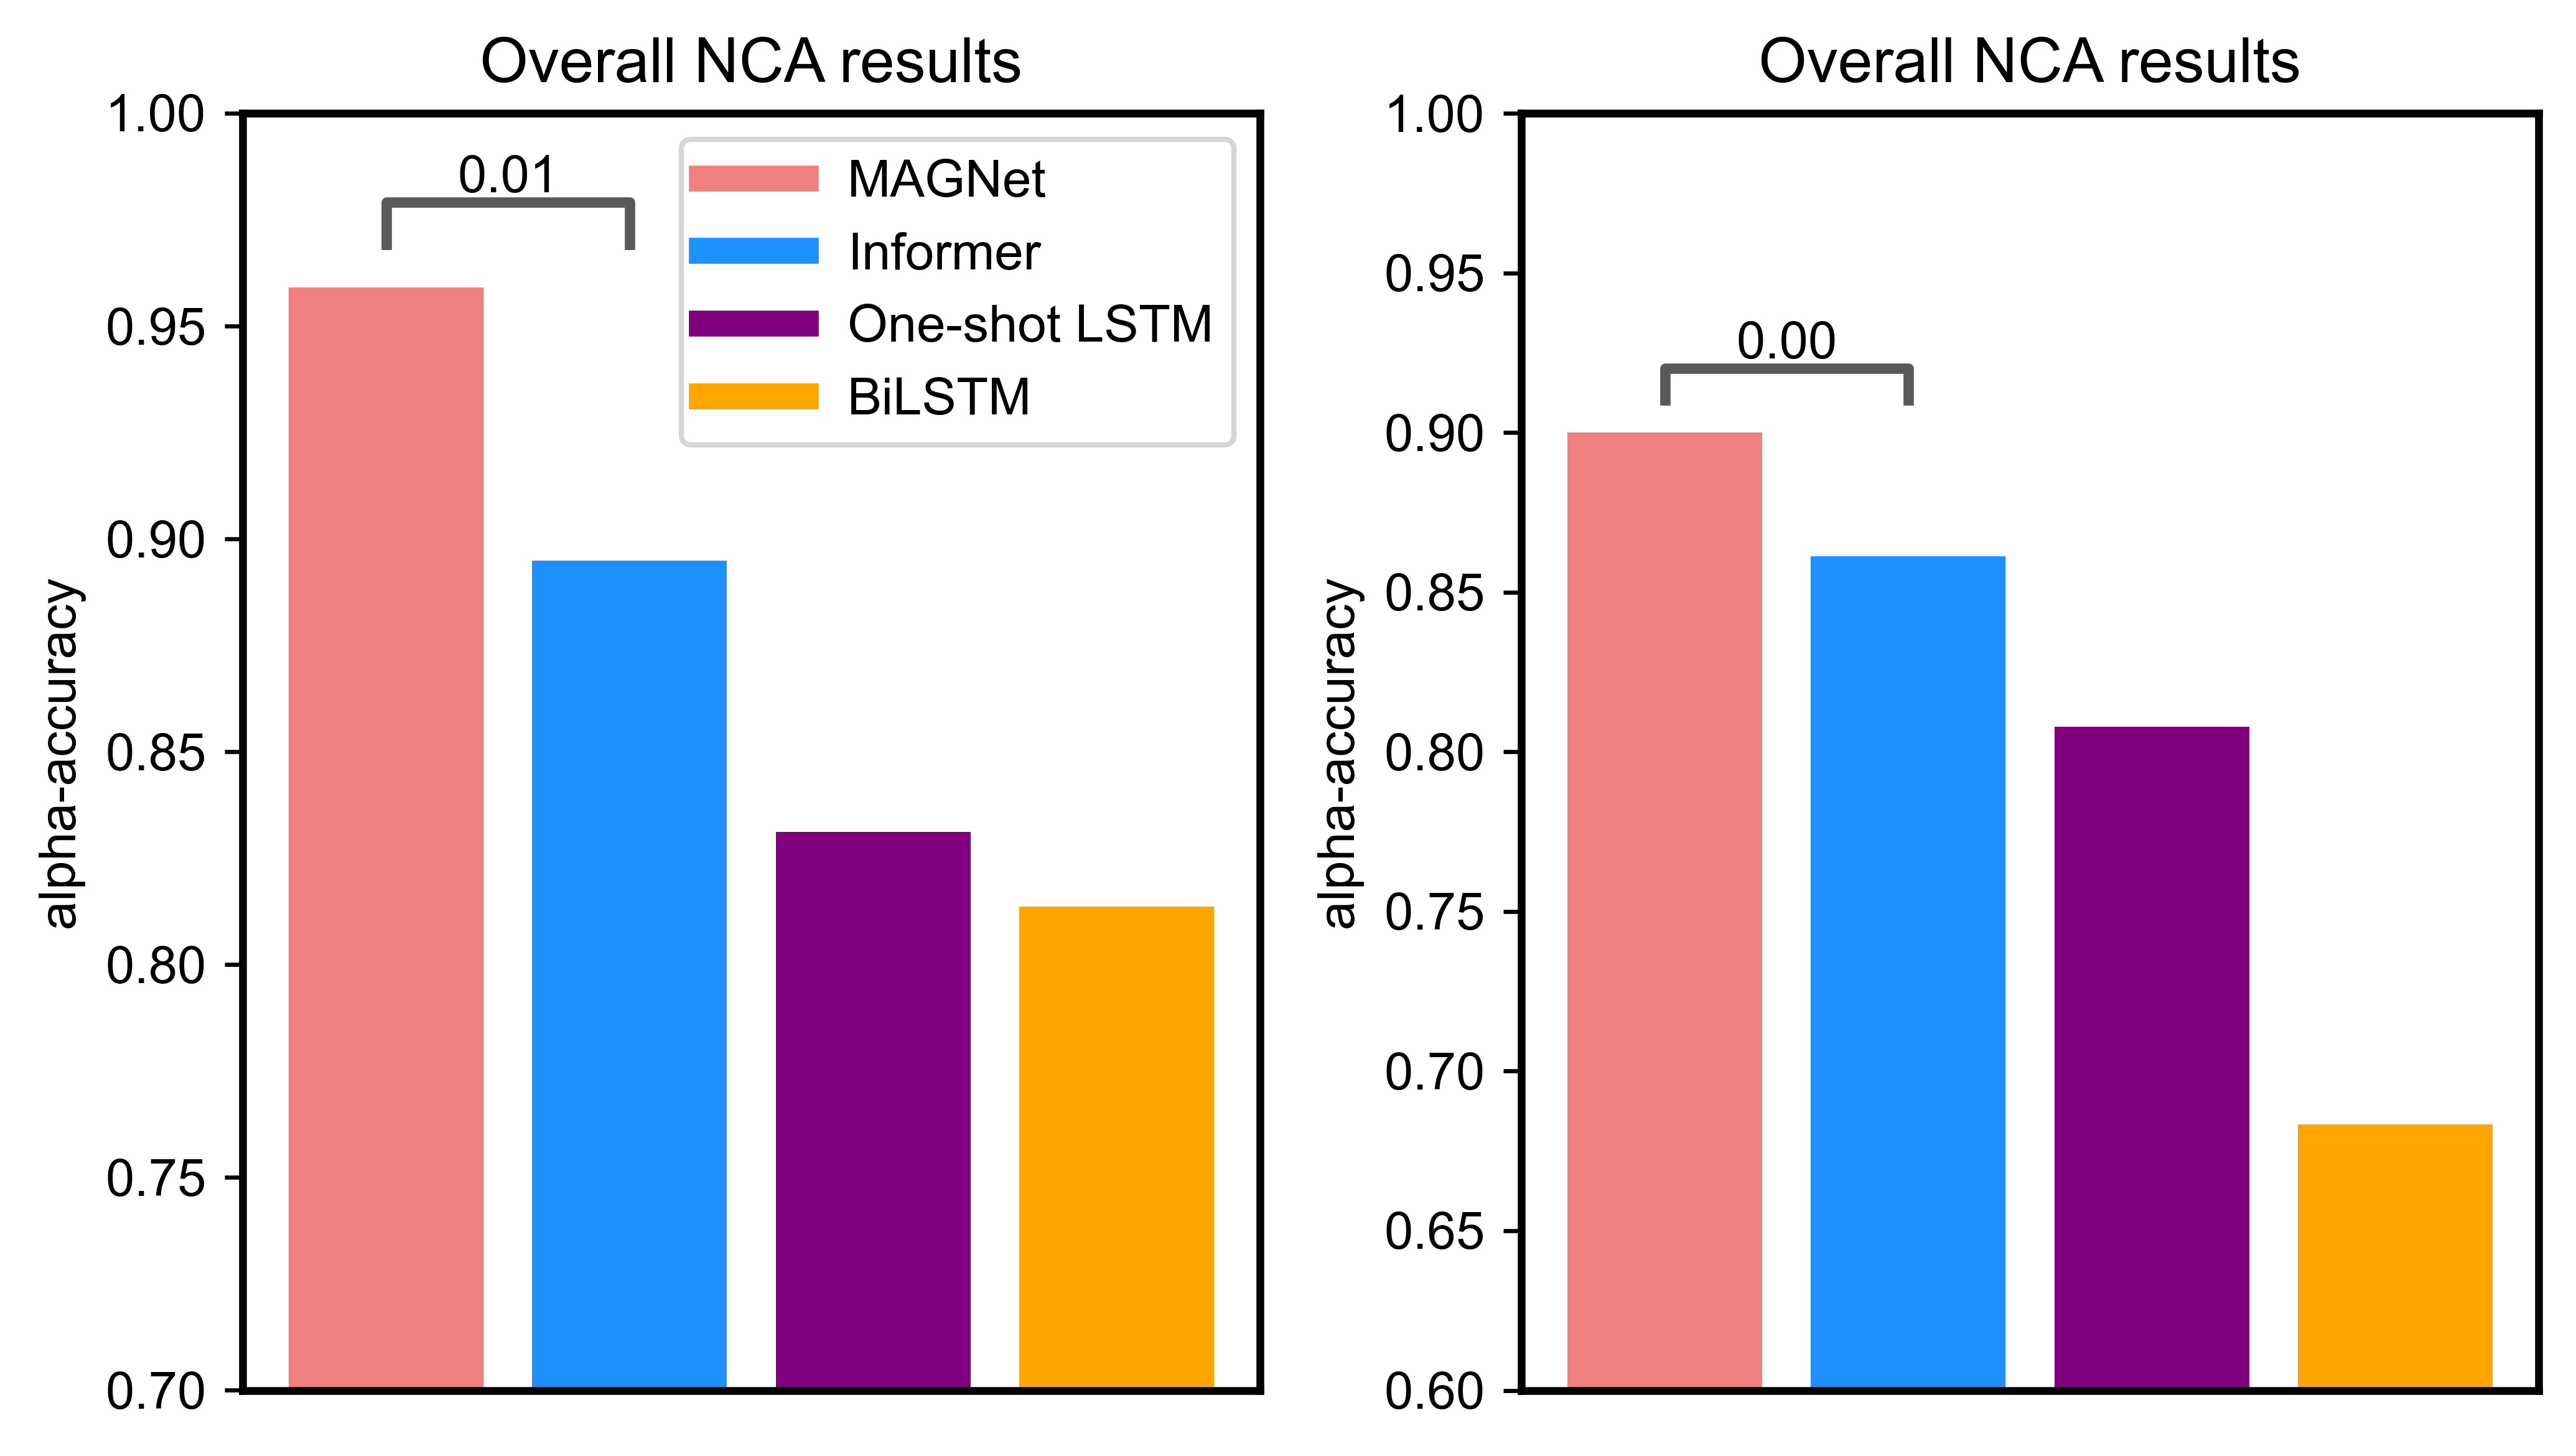

In [28]:
plot_overal_performance(NCA_model_paths,LFP_model_paths)

In [29]:
# plot_alphaAcc_vs_sampleRatio(NCA_model_paths)

用箱线图表示各个模型在NCA数据集上的表现

{'CY25-1': 0.9756684981684982, 'CY25-05': 0.9607116573885489, 'CY45-05': 0.9916421955165207, 'CY25-025': 0.8725889908535865, 'CY35-05': 0.9950975402883799}
{'CY25-1': 0.653867451992452, 'CY25-05': 0.9370650144972221, 'CY45-05': 0.9923819475920601, 'CY25-025': 0.8984739097797947, 'CY35-05': 0.9929431721798134}
{'CY25-1': 0.9714996114996115, 'CY25-05': 0.44308139701890803, 'CY45-05': 0.5150606528081163, 'CY25-025': 0.45715722339999565, 'CY35-05': 0.38569853611896165}
{'CY25-1': 1.0, 'CY25-05': 0.9208209370602585, 'CY45-05': 0.9897481566880287, 'CY25-025': 0.8163288315440768, 'CY35-05': 0.9925338379626659}


meta NOT subset; don't know how to subset; dropped


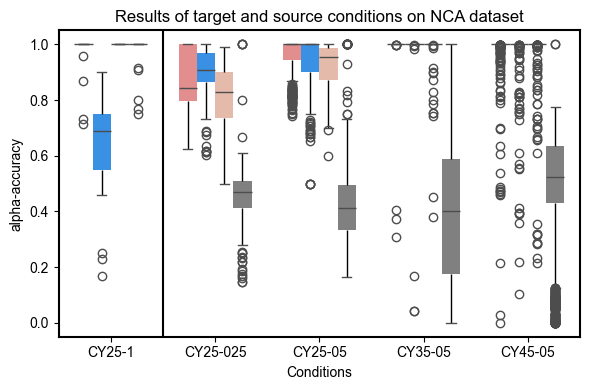

In [30]:
plot_NCA_target_source_boxes(NCA_model_paths)

{'CY25-1': 0.9756684981684982, 'CY25-05': 0.9607116573885489, 'CY45-05': 0.9916421955165207, 'CY25-025': 0.8725889908535865, 'CY35-05': 0.9950975402883799}
{'CY25-1': 0.653867451992452, 'CY25-05': 0.9370650144972221, 'CY45-05': 0.9923819475920601, 'CY25-025': 0.8984739097797947, 'CY35-05': 0.9929431721798134}
{'CY25-1': 0.6329088041588041, 'CY25-05': 0.8728494939419226, 'CY45-05': 0.9798593953109191, 'CY25-025': 0.7450411583707417, 'CY35-05': 0.9254877014419}
{'CY25-1': 0.615030895030895, 'CY25-05': 0.9016542185159016, 'CY45-05': 0.9767196094560623, 'CY25-025': 0.6816103145935466, 'CY35-05': 0.8930551537717887}
{'CY25-1': 0.9714996114996115, 'CY25-05': 0.44308139701890803, 'CY45-05': 0.5150606528081163, 'CY25-025': 0.45715722339999565, 'CY35-05': 0.38569853611896165}
{'CY25-1': 1.0, 'CY25-05': 0.9208209370602585, 'CY45-05': 0.9897481566880287, 'CY25-025': 0.8163288315440768, 'CY35-05': 0.9925338379626659}


meta NOT subset; don't know how to subset; dropped


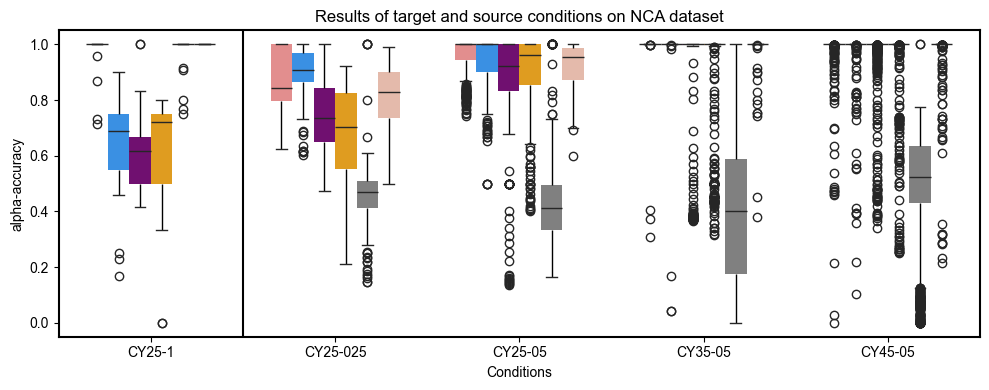

In [31]:
plot_NCA_target_source_boxes_all(NCA_model_paths)

6C(20%)-4.5C 0.12143631856213195
4.9C(27%)-4.75C 0.08609970380782543
6C(40%)-4C 0.07289532044612868
5.6C(47%)-4C 0.06836620952402074
5.2C(71%)-3C 0.059324784937510124
5.6C(58%)-3.5C 0.05579951967959346
6C(31%)-4.25C 0.047278724573941694
5.6C(65%)-3C 0.04234236528680241
6C(52%)-3.5C 0.023163669612922887
3.6C(22%)-5.5C 0.017677280939476177
4.4C(55%)-6C 0.010668865899121149
4C(31%)-5C 0.01007033605001678
2C(2%)-5C -0.011654309545875898
1C(4%)-6C -0.018182867697991215
2C(7%)-5.5C -0.05879783125950764
2C(10%)-6C -0.18731365919700532


meta NOT subset; don't know how to subset; dropped


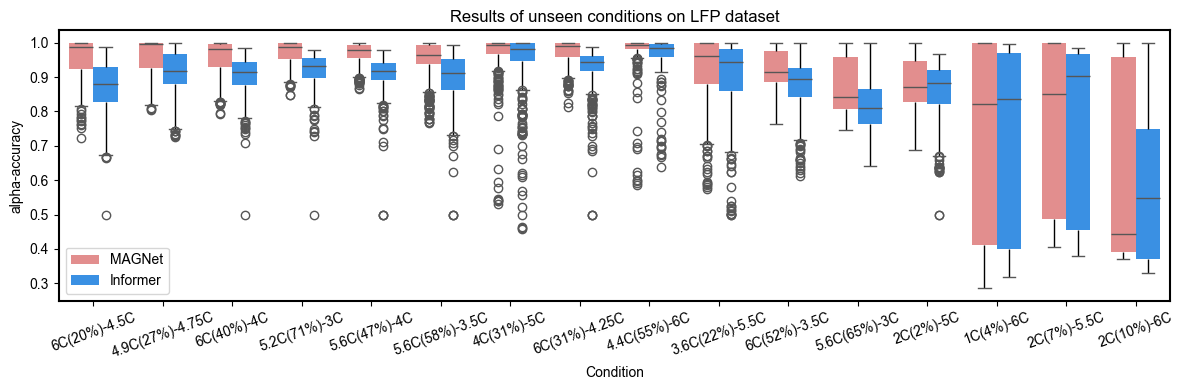

In [32]:
plot_LFP_seen_unseen_boxes(LFP_model_paths, rank_from_large_imrpvoement_to_low=True)